In [ ]:
%cd /content/drive/MyDrive/compvis/Multi_instance/

/content/drive/MyDrive/compvis/Multi_instance


In [ ]:
!pwd 

/content/drive/MyDrive/compvis/Multi_instance


In [ ]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

In [ ]:
# initialize COCO api for instance annotations
coco=COCO('/content/drive/MyDrive/compvis/Multi_instance/instances_val2014.json')

loading annotations into memory...
Done (t=10.11s)
creating index...
index created!


In [ ]:
catIds = coco.getCatIds(catNms=['dog','person']);
catIds

[1, 18]

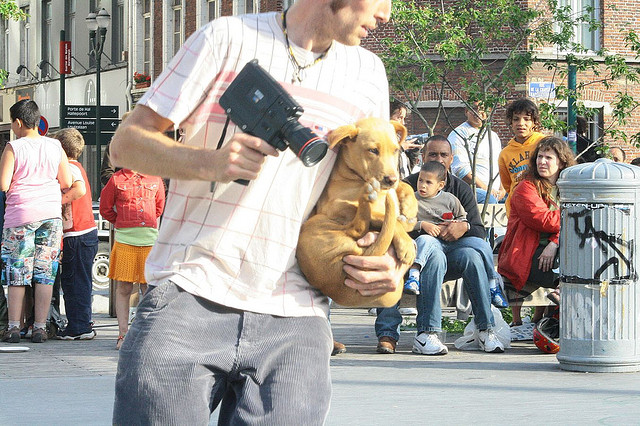

In [ ]:
from PIL import Image
#Image.open('images/pexels-anna-tarazevich-6027374.jpg')
Image.open('people_and_dogs_COCO/COCO_val2014_000000008787.jpg').convert('RGB')
#Image.open('images/pexels-anna-tarazevich-6027374.jpg').convert('P').convert('RGB')
#Image.open('images/pexels-anna-tarazevich-6027374.jpg').convert('P')
#Image.open('images/pexels-anna-tarazevich-6027374.jpg').convert('L')

In [ ]:
import json 
data_json = json.loads(open('/content/drive/MyDrive/compvis/Multi_instance/instances_val2014.json').read())
#data

In [ ]:
for ii in data_json['images']:
  if ii['file_name'] == 'COCO_val2014_000000008787.jpg':
    imgId = ii['id']

In [ ]:
# imgId

In [ ]:
# annIds = coco.getAnnIds(imgIds=imgId, catIds=catIds, iscrowd=None)
# annIds

In [ ]:
# for ii in anns:
#   print(ii['category_id'])

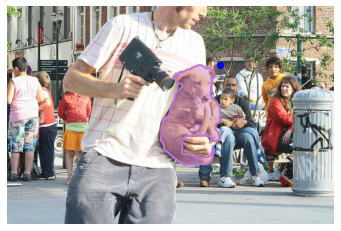

In [ ]:
# load and display instance annotations
I = Image.open('people_and_dogs_COCO/COCO_val2014_000000008787.jpg').convert('RGB')
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=imgId, catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns[:1])
for i in range(1):
    xmin = int(anns[i]['bbox'][0])
    xmax = int(anns[i]['bbox'][0]+anns[i]['bbox'][2])
    ymin = int(anns[i]['bbox'][1])
    ymax = int(anns[i]['bbox'][1]+anns[i]['bbox'][3])
    plt.plot(xmax,ymin,'bo')
plt.show()

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(root+ "/people_and_dogs_COCO")))
        self.data_json = json.loads(open(root+'/instances_val2014.json').read())
        self.catIds = [1,18]

    def __getitem__(self, idx):

        for ii in self.data_json['images']:
          if ii['file_name'] == self.imgs[idx]:
            imgId = ii['id']
        img = Image.open(self.root+'/people_and_dogs_COCO/'+self.imgs[idx]).convert("RGB")

        annids = coco.getAnnIds(imgIds=imgId, catIds=self.catIds, iscrowd=None)
        anns = coco.loadAnns(annids)
        labels = []
        for ii in anns:
          labels.append(ii['category_id'])
        labels = [2 if x==18 else x for x in labels]

        masks = []
        for ii in anns:
          masks.append(coco.annToMask(ii))
        
        for ii in masks:
          ii = np.where(ii == 18, 2, ii)
        
        num_objs = len(masks)

        boxes = []
        for i in range(num_objs):
            xmin = int(anns[i]['bbox'][0]) #May not need int now, migth work with float
            xmax = int(anns[i]['bbox'][0]+anns[i]['bbox'][2])
            ymin = int(anns[i]['bbox'][1])
            ymax = int(anns[i]['bbox'][1]+anns[i]['bbox'][3]) #To me the y ones seem swapped
            boxes.append([xmin, ymin, xmax, ymax])
            # pos = np.where(masks[i])
            # xmin = np.min(pos[1])
            # xmax = np.max(pos[1])
            # ymin = np.min(pos[0])
            # ymax = np.max(pos[0])
            # if xmin == xmax: #To fix boxes that caused errors, probably better solution
            #   xmax = xmax+1
            # if ymin == ymax:
            #   ymax = ymax+1
            # boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
imgs = list(sorted(os.listdir("./people_and_dogs_COCO")))
data_json = json.loads(open('./instances_val2014.json').read())
catIds = [1,18]

for ii in data_json['images']:
  if ii['file_name'] == imgs[0]:
    imgId = ii['id']
img = Image.open('./people_and_dogs_COCO/'+imgs[0]).convert("RGB")

annids = coco.getAnnIds(imgIds=imgId, catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annids)
labels = []
for ii in anns:
  labels.append(ii['category_id'])
labels = [2 if x==18 else x for x in labels]

masks = []
for ii in anns:
  masks.append(coco.annToMask(ii))

for ii in masks:
  ii = np.where(ii == 18, 2, ii)

num_objs = len(masks)

boxes = []
for i in range(num_objs):
    xmin = int(anns[i]['bbox'][0])
    xmax = int(anns[i]['bbox'][0]+anns[i]['bbox'][2])
    ymin = int(anns[i]['bbox'][1])
    ymax = int(anns[i]['bbox'][1]+anns[i]['bbox'][3])
    boxes.append([xmin, ymin, xmax, ymax])
    #print([xmin, ymin, xmax, ymax])
    # pos = np.where(masks[i])
    # xmin = np.min(pos[1])
    # xmax = np.max(pos[1])
    # ymin = np.min(pos[0])
    # ymax = np.max(pos[0])
    # if xmin == xmax: #To fix boxes that caused errors, probably better solution
    #   xmax = xmax+1
    # if ymin == ymax:
    #   ymax = ymax+1
    # #print([xmin, ymin, xmax, ymax])
    # boxes.append([xmin, ymin, xmax, ymax])

boxes = torch.as_tensor(boxes, dtype=torch.float32)

labels = torch.as_tensor(labels, dtype=torch.int64)
masks = torch.as_tensor(masks, dtype=torch.uint8)

image_id = torch.tensor([0])

area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

target = {}
target["boxes"] = boxes
target["labels"] = labels
target["masks"] = masks
target["image_id"] = image_id
target["area"] = area
target["iscrowd"] = iscrowd

print(target)

{'boxes': tensor([[ 61., 276., 358., 379.],
        [295.,  93., 313., 152.],
        [326.,  97., 340., 122.],
        [356.,  95., 372., 147.],
        [462., 105., 493., 146.],
        [277., 103., 292., 150.],
        [282., 103., 294., 127.]]), 'labels': tensor([2, 1, 1, 1, 1, 1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features #What does cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels #what does conv5_mask.in_channels mean?
    hidden_layer = 256 #Where does hidden layer come from, how do we know 256, what happens if changed?
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []

    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())

    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms) #This and T.ToTensor() found in pretrained one

# use our dataset and defined transformations
dataset = Dataset('/content/drive/MyDrive/compvis/Multi_instance', get_transform(train=True))
dataset_test = Dataset('/content/drive/MyDrive/compvis/Multi_instance', get_transform(train=False))

# split the dataset in train and test set, the way its done above could there not be overlap between two, does this matter?
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [ ]:
dataset[0]

(tensor([[[0.2627, 0.1804, 0.2196,  ..., 0.0549, 0.1020, 0.1412],
          [0.1529, 0.2824, 0.1529,  ..., 0.1490, 0.2745, 0.2235],
          [0.3294, 0.2588, 0.2627,  ..., 0.4235, 0.5059, 0.2588],
          ...,
          [0.4000, 0.3490, 0.3647,  ..., 0.2980, 0.2157, 0.2039],
          [0.3922, 0.4353, 0.4275,  ..., 0.2235, 0.1804, 0.2157],
          [0.3255, 0.4039, 0.4196,  ..., 0.2235, 0.1882, 0.2118]],
 
         [[0.2510, 0.1686, 0.2039,  ..., 0.0431, 0.0824, 0.1098],
          [0.1412, 0.2706, 0.1373,  ..., 0.1216, 0.2353, 0.1725],
          [0.3176, 0.2471, 0.2471,  ..., 0.3843, 0.4510, 0.1922],
          ...,
          [0.3686, 0.3176, 0.3412,  ..., 0.2824, 0.2000, 0.1961],
          [0.3529, 0.3961, 0.3882,  ..., 0.2275, 0.1843, 0.2196],
          [0.2863, 0.3647, 0.3804,  ..., 0.2275, 0.1922, 0.2157]],
 
         [[0.2157, 0.1412, 0.1922,  ..., 0.0157, 0.0588, 0.0980],
          [0.1059, 0.2431, 0.1255,  ..., 0.0902, 0.2000, 0.1490],
          [0.2902, 0.2196, 0.2353,  ...,

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person, could change if more?
num_classes = 3

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device, why is this done?
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [26]:
# number of epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/313]  eta: 0:12:05  lr: 0.000021  loss: 0.5763 (0.5763)  loss_classifier: 0.0932 (0.0932)  loss_box_reg: 0.2338 (0.2338)  loss_mask: 0.2306 (0.2306)  loss_objectness: 0.0064 (0.0064)  loss_rpn_box_reg: 0.0123 (0.0123)  time: 2.3171  data: 0.5256  max mem: 4057
Epoch: [0]  [ 10/313]  eta: 0:09:51  lr: 0.000181  loss: 0.5901 (0.6521)  loss_classifier: 0.1437 (0.1469)  loss_box_reg: 0.1959 (0.2138)  loss_mask: 0.2625 (0.2631)  loss_objectness: 0.0112 (0.0107)  loss_rpn_box_reg: 0.0154 (0.0176)  time: 1.9526  data: 0.0581  max mem: 4057
Epoch: [0]  [ 20/313]  eta: 0:09:35  lr: 0.000341  loss: 0.6364 (0.6669)  loss_classifier: 0.1165 (0.1433)  loss_box_reg: 0.1932 (0.2137)  loss_mask: 0.2625 (0.2698)  loss_objectness: 0.0112 (0.0177)  loss_rpn_box_reg: 0.0138 (0.0225)  time: 1.9469  data: 0.0114  max mem: 4057
Epoch: [0]  [ 30/313]  eta: 0:09:12  lr: 0.000501  loss: 0.7314 (0.7032)  loss_classifier: 0.1189 (0.1481)  loss_box_reg: 0.2231 (0.2235)  loss_mask: 0.2487 (0.2741) 

In [27]:
#torch.save(model, 'mask-rcnn-custom-instance.pt')

In [28]:
# set to evaluation mode
model.eval()
CLASS_NAMES = ['__background__', 'person', 'dog']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [29]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')

def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, confidence):

    #Comments on workings of this in pretrained notebook


    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class, pred_score

def segment_instance(img_path, confidence=0.5, rect_th=2, text_size=2, text_th=2):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    masks, boxes, pred_cls, pred_scr = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
      rgb_mask = get_coloured_mask(masks[i])
      if i == 0:
        rgb_orig = rgb_mask
      if i == 1:
        img_2 = cv2.addWeighted(rgb_mask, 1, rgb_orig, 1, 0)
      if i > 0:
        img_2 = cv2.addWeighted(rgb_mask, 1, img_2, 1, 0)
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
      cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
      cv2.putText(img,str(pred_scr[i]), (int(boxes[i][0][0]+20),int(boxes[i][0][1]+30)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    #plt.imshow(img_2)
    plt.xticks([])
    plt.yticks([])
    print(len(masks))
    plt.show()

2


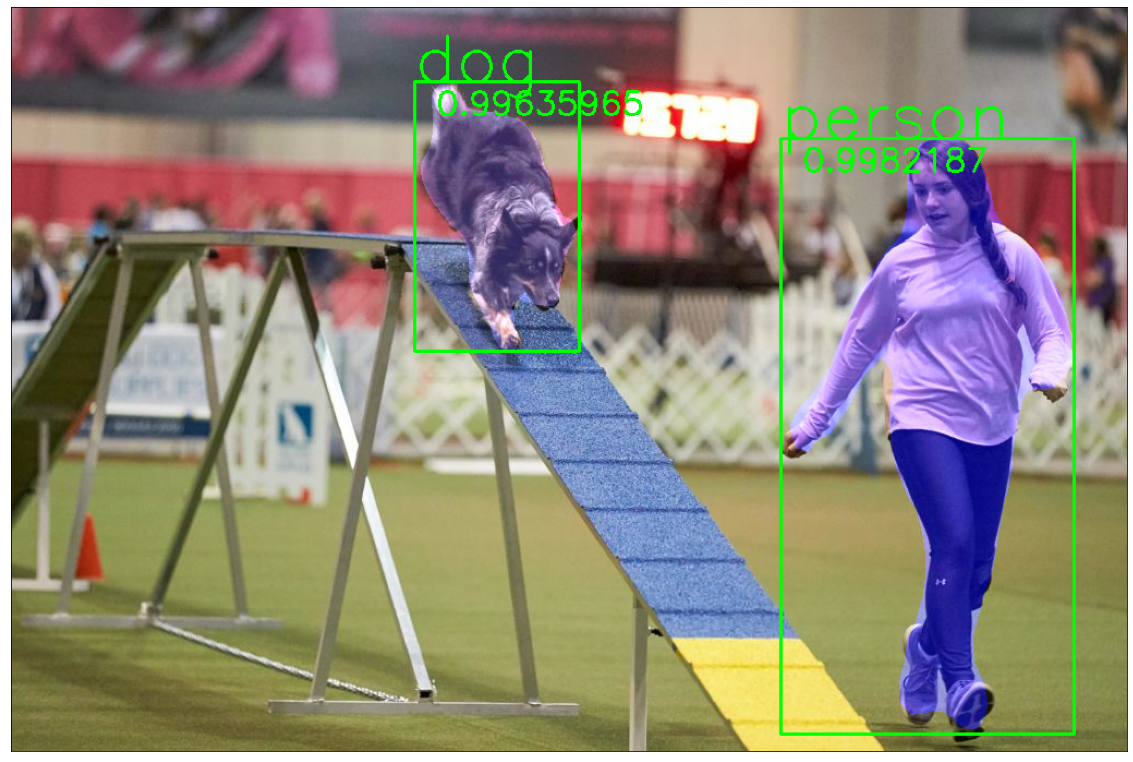

In [34]:
segment_instance('/content/2018-AKC-Agility-Juniors-AKC_6580-David-Woo.20190628170846165-1024x683.jpg', confidence=0.99)

2


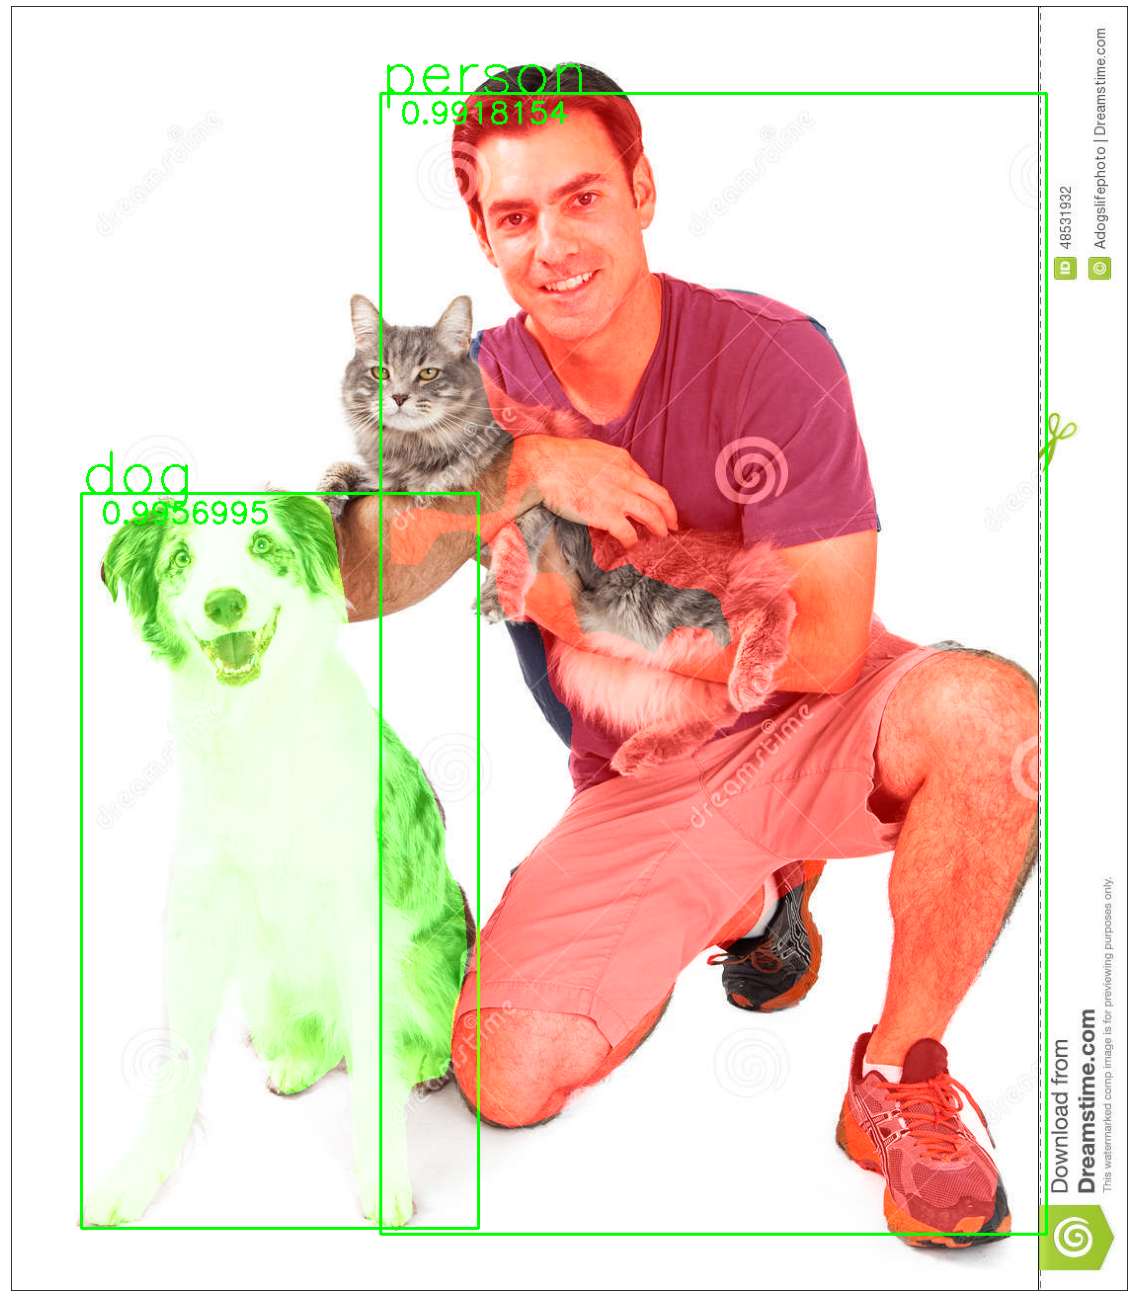

In [35]:
segment_instance('/content/handsome-man-dog-cat-young-holding-kneeling-next-to-cute-border-collie-48531932.jpg', confidence=0.99)